### Importing and pre-processing data

In [23]:
import json
import string
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import math
f = open('speeches.json',)
unprocessed_speeches = []
for line in f:
    unprocessed_speeches.append(json.loads(line))
    
import re
pattern_sentence = re.compile(r'([A-Z][^\.!?]*[\.!?]+)')
def parse_sentence(speeches):
    n = len(speeches)
    parsed_speeches = []
    for i in range(n):
        speech = speeches[i]['text']
        parsed_speeches.append(pattern_sentence.findall(speech))
    return(parsed_speeches)

SOU_sentences = parse_sentence(unprocessed_speeches)

### 4(a)

In [2]:
def clean_and_split(s):
    # encode to UTF-8, convert to lowercase and translate all hyphens and
    # punctuation to whitespace
    s = s.lower()
    for c in (string.punctuation):
        s = s.replace(c, " ") # getting rid of punctuation
    s = s.replace('-',' ') # getting rid of hyphen
    s = re.sub('\r\n',' ',s) # replace \r\n
    # replace whitespace substrings with one whitespace and remove
    # leading/trailing whitespaces
    s = re.sub(' +',' ',s.strip())
    return s.split(' ')

def parse_words(sentences): # convert a SOU into word lists 
    by_words = []
    for sentence in sentences:
        words = clean_and_split(sentence)
        for word in words:
            by_words.append(word)
    return(by_words)

class SOU: # create a SOU class for later processing 
    def __init__(self,word_list,sentence_list,president,year):
        self.Words = word_list
        self.Sentences = sentence_list
        self.President = president
        self.Year = year
    def unique_words(self):
        unique_words = list(set(self.Words))
        return(unique_words)
    def word_counts(self): 
        word_counts = {}
        unique_words = list(set(self.Words))
        for key in unique_words:
            word_counts[key] = 0
        words = self.Words
        for word in words:
            word_counts[word] = word_counts[word] + 1
        return(word_counts)
    def set_tfidf_vec(self,tfidf_vec): # append tfidf vector attribute
        self.TFIDF = tfidf_vec 

In [3]:
# Parse all SOUs and create SOU class objects

def process_SOUs(unprocessed_speeches,SOU_sentences):
    speeches = []
    number_speeches = len(unprocessed_speeches)
    for i in range(number_speeches):
        sou_word_lists = parse_words(SOU_sentences[i])
        speech = SOU(sou_word_lists,SOU_sentences[i],unprocessed_speeches[i]['president'],unprocessed_speeches[i]['year'])
        speeches.append(speech)
    return(speeches)

In [4]:
# Create TF-IDF vector:

# Step 1: Create list of SOU class objects
processed_SOUs = process_SOUs(unprocessed_speeches,SOU_sentences)

# Step 2: Define auxilliary functions
def merge_word_lists(SOUs): # collapse all word count dictionaries from all SOUs into one single dictionary
    dicts = []
    for SOU in SOUs:
        dicts.append(SOU.word_counts())
    master_list = {}
    for sou in dicts:
        for key in sou:
            if key in master_list:
                master_list[key] = master_list[key] + sou[key]
            else:
                master_list[key] = sou[key]
    return(master_list)
 
def cleanup_master_list(master_list,cut_off_high,cut_off_low): # get rid of most common and least common words
    sorted_list = sorted(master_list.items(),key=lambda x:x[1])
    sorted_list_get_rid_of_top = sorted_list[:-cut_off_high] # get rid of most common words
    sorted_list_get_rid_of_bottom = []
    for pair in sorted_list_get_rid_of_top:
        if pair[1] >= cut_off_low:  # get rid of least common words
            sorted_list_get_rid_of_bottom.append(pair)
    return(sorted_list_get_rid_of_bottom)

def number_documents_containing(processed_SOUs,target_word): # get number of documents that contain a target word
    d = 0
    unique_words_list = []
    for SOU in processed_SOUs:
        if target_word in SOU.unique_words():
            d = d+1
    return(d)

def create_freq_list(processed_SOUs,master_list): 
    # create a dictionary with words and the number of documents they appear in
    master_list_freqs = {}
    i = 0
    for pair in master_list:
        word = pair[0]
        n = number_documents_containing(processed_SOUs,word)
        master_list_freqs[word] = n
    return(master_list_freqs)

def tfidf(processed_SOUs,master_list,freq_list):
    D = len(processed_SOUs)
    V = len(master_list)
    tf_idf_vecs = []
    for d in range(D):
        document = processed_SOUs[d]
        document_word_counts = document.word_counts()
        document_unique_words = document.unique_words()
        tf_idf_vec = []
        for i in range(V):
            target_word = master_list[i][0]
            freq_all = freq_list[target_word]
            if target_word in document_unique_words:
                ni_d = document_word_counts[target_word]
            else:
                ni_d = 0
            wi_d = ni_d * math.log(D/freq_all)
            tf_idf_vec.append(wi_d)
        tf_idf_vecs.append(tf_idf_vec)
    return(tf_idf_vecs)

In [5]:
cleaned_master_list = cleanup_master_list(merge_word_lists(processed_SOUs),20,50)
freq_list = create_freq_list(processed_SOUs,cleaned_master_list)

In [6]:
# attach the computed tf-idf vectors to each SOU object for later processing
tf_idfs = tfidf(processed_SOUs,cleaned_master_list,freq_list)
for i in range(len(tf_idfs)):
    processed_SOUs[i].set_tfidf_vec(tf_idfs[i])

### 4(b)

In [7]:
def compute_similarity(sou1,sou2):
    # function for computing similarity score
    tf_idf1 = sou1.TFIDF
    tf_idf2 = sou2.TFIDF
    sim_score =  np.dot(tf_idf1,tf_idf2) / (np.linalg.norm(tf_idf1) * np.linalg.norm(tf_idf2))
    return(sim_score)

def compute_similarity_matrix(processed_SOUs):
    # return a matrix for similarity scores
    # we only care about the upper triangular, off-diagonal part, so create an upper-triangular matrix
    D = len(processed_SOUs)
    similarity_mat = np.zeros((D,D))
    for i in range(D):
        for j in range(D):
            if i <= j:
                sou1 = processed_SOUs[i]
                sou2 = processed_SOUs[j]
                similarity_mat[i,j] = compute_similarity(sou1,sou2)
    return(similarity_mat)

def compute_president_matrix(processed_SOUs):
    # return a boolean array where if (i,j)th entry is 1 means 
    # i-th document and j-th document are by the same president
    # we only care about the upper triangular, off-diagonal part, so create an upper-triangular matrix
    D = len(processed_SOUs)
    president_mat = np.zeros((D,D))
    for i in range(D):
        for j in range(D):
            if i <= j:
                sou1 = processed_SOUs[i]
                sou2 = processed_SOUs[j]
                president_mat[i,j] = (sou1.President == sou2.President)
    return(president_mat)

def compute_sim_scores(processed_SOUs):
    # produce a list of 3-pules, the first entry is the similarity score, second entry is the id of SOUs
    # third index indicates whether the pair of SOUs comes from the same president (1 if yes, 0 if no)
    similarity_matrix = compute_similarity_matrix(processed_SOUs)
    president_matrix = compute_president_matrix(processed_SOUs)
    sim_scores = []
    D = len(processed_SOUs)
    for i in range(D):
        for j in range(D):
            if i<j:
                sim_score = similarity_matrix[i,j]
                president_same = president_matrix[i,j]
                index = (i,j)
                sim_scores.append((sim_score,president_same,index))
    return(sim_scores)

### 50 most similar pairs of SOUs given by different Presidents

In [8]:
sim_scores = compute_sim_scores(processed_SOUs)

In [9]:
diff_presidents_sorted = list(filter(lambda x: x[1]!=1,sorted(sim_scores,key=lambda x:x[0],reverse=True)))

In [10]:
diff_presidents_sorted[0:49]

[(0.7248246043534841, 0.0, (22, 50)),
 (0.7217028462778502, 0.0, (50, 91)),
 (0.7124973636046079, 0.0, (50, 138)),
 (0.6908748431727865, 0.0, (50, 177)),
 (0.672085151409242, 0.0, (22, 71)),
 (0.6668535920062889, 0.0, (71, 177)),
 (0.6629775893507349, 0.0, (71, 91)),
 (0.6583714722668585, 0.0, (91, 177)),
 (0.6570186983651323, 0.0, (71, 138)),
 (0.6550204628580997, 0.0, (91, 196)),
 (0.6510432249308671, 0.0, (38, 50)),
 (0.6495061241788253, 0.0, (48, 91)),
 (0.6457152779269416, 0.0, (22, 177)),
 (0.6399639579161642, 0.0, (22, 196)),
 (0.6393140329918028, 0.0, (38, 71)),
 (0.625811725619095, 0.0, (38, 177)),
 (0.6206534483898205, 0.0, (124, 152)),
 (0.615228867737172, 0.0, (138, 177)),
 (0.6140177687962247, 0.0, (89, 114)),
 (0.6134780726708445, 0.0, (22, 48)),
 (0.6110028176049613, 0.0, (38, 196)),
 (0.610049939919789, 0.0, (43, 85)),
 (0.6087420232793072, 0.0, (177, 196)),
 (0.6070844797370145, 0.0, (58, 196)),
 (0.607009578322454, 0.0, (31, 114)),
 (0.605432036088757, 0.0, (48, 114))

### 50 most similar pairs of SOUs given by the same President

In [11]:
same_presidents_sorted = list(filter(lambda x: x[1]==1,sorted(sim_scores,key=lambda x:x[0],reverse=True)))
same_presidents_sorted[0:49]

[(0.826150707566682, 1.0, (143, 200)),
 (0.8117331924763175, 1.0, (22, 138)),
 (0.8004459969630424, 1.0, (22, 91)),
 (0.7958708316590685, 1.0, (91, 138)),
 (0.7672573846077625, 1.0, (50, 71)),
 (0.757396935501319, 1.0, (22, 38)),
 (0.7462082052690785, 1.0, (48, 57)),
 (0.7403904857707183, 1.0, (48, 222)),
 (0.7390810651308907, 1.0, (48, 66)),
 (0.7357283964767966, 1.0, (29, 153)),
 (0.7252855077322765, 1.0, (60, 138)),
 (0.7234337491428953, 1.0, (57, 66)),
 (0.7209307424299797, 1.0, (200, 209)),
 (0.7167897523419083, 1.0, (143, 189)),
 (0.7147077150371427, 1.0, (57, 222)),
 (0.7142987805131197, 1.0, (38, 138)),
 (0.7062446460234796, 1.0, (143, 209)),
 (0.704784159943305, 1.0, (186, 191)),
 (0.7004696603396164, 1.0, (38, 91)),
 (0.6906534782680663, 1.0, (189, 200)),
 (0.6896248899860037, 1.0, (50, 196)),
 (0.6861757321567771, 1.0, (119, 151)),
 (0.6799162254997183, 1.0, (52, 189)),
 (0.679182418317831, 1.0, (11, 88)),
 (0.6768369092259289, 1.0, (58, 169)),
 (0.67639937854745, 1.0, (52, 

### 25 most similar pairs of Presidents, average the cosine similarity over all pairs of their SOUs

In [12]:
def by_presidents(processed_SOUs):
    presidents_addresses = {}
    D = len(processed_SOUs)
    for i in range(D):
        SOU = processed_SOUs[i]
        president = SOU.President
        if president in presidents_addresses:
            presidents_addresses[president].append(i)
        else:
            presidents_addresses[president] = [i,]
    similarity_matrix = compute_similarity_matrix(processed_SOUs)
    number_presidents = len(presidents_addresses)
    pairs = []
    for i in range(number_presidents):
        for j in range(number_presidents):
            if i<j:
                presi = list(presidents_addresses.keys())[i]
                presj = list(presidents_addresses.keys())[j]
                sou_indexes_i = presidents_addresses[presi]
                sou_indexes_j = presidents_addresses[presj]
                total_addresses = len(sou_indexes_i) * len(sou_indexes_j)
                total_scores = 0
                for a in sou_indexes_i:
                    for b in sou_indexes_j:
                        total_scores = total_scores + similarity_matrix[a,b]
                avg_sim = total_scores / total_addresses
                pairs.append(((presi,presj),avg_sim))
    return([pairs,presidents_addresses])

In [13]:
output = by_presidents(processed_SOUs)
pair_scores = by_presidents(processed_SOUs)[0]
most_sim_pair_sorted = sorted(pair_scores,key=lambda x:x[1],reverse=True)
most_sim_pair_sorted[0:24]

[(('Millard Fillmore', 'Zachary Taylor'), 0.49984248780334867),
 (('Rutherford B. Hayes', 'Chester A. Arthur'), 0.3944811632153003),
 (('Barack Obama', 'William J. Clinton'), 0.37096425617291706),
 (('Millard Fillmore', 'Chester A. Arthur'), 0.3627634029937756),
 (('Theodore Roosevelt', 'William Howard Taft'), 0.3626871546761424),
 (('Barack Obama', 'George W. Bush'), 0.34513402013229183),
 (('William Howard Taft', 'Zachary Taylor'), 0.34258798845342275),
 (('Grover Cleveland', 'Chester A. Arthur'), 0.34086336182046123),
 (('Barack Obama', 'Ronald Reagan'), 0.3310853256696489),
 (('Benjamin Harrison', 'Chester A. Arthur'), 0.32701447959701685),
 (('Abraham Lincoln', 'Zachary Taylor'), 0.3189170410143515),
 (('Rutherford B. Hayes', 'Zachary Taylor'), 0.317055614449803),
 (('James K. Polk', 'Zachary Taylor'), 0.31460636279313514),
 (('Barack Obama', 'Gerald R. Ford'), 0.31272877569448526),
 (('Franklin Pierce', 'Zachary Taylor'), 0.30614112016611317),
 (('Andrew Johnson', 'Chester A. Art

### Comments on results:

In [15]:
most_sim_pair_sorted[0]

(('Millard Fillmore', 'Zachary Taylor'), 0.49984248780334867)

Starting with the most similar pair of presidents, we see that William Fillmore became president right after Zachary Taylor in the 1850s, so the similarity is reasonable. Furthermore, Zachary Taylor only had one SOU, which may have limited the range of topics / speech styles and as a result pushed up his similarity to William Fillmore by chance. 

In [16]:
same_presidents_sorted[0]

(0.826150707566682, 1.0, (143, 200))

In [17]:
(processed_SOUs[143].President,processed_SOUs[143].Year,processed_SOUs[200].President,processed_SOUs[200].Year)

('George W. Bush', '2007', 'George W. Bush', '2008')

The most similar pair of SOUs given by the same president is George W.Bush's 2007 and 2008 speeches. George W.Bush has 8 speeches, but it would make sense that the most similar pair is from consecutive years due to topic similarity. 

In [18]:
diff_presidents_sorted[0]

(0.7248246043534841, 0.0, (22, 50))

In [19]:
(processed_SOUs[22].President,processed_SOUs[22].Year,processed_SOUs[50].President,processed_SOUs[50].Year)

('Barack Obama', '2010', 'William J. Clinton', '1995')

The most similar pair of speeches by different president is Obama 2010 and Clinton 1995. While not at first apparent, both speeches address the fact that the two presidents came to office at time of crisis and reflects on their presidency so far and ways forward. There were ovarlapping topics including addressing issues in North Korea and reflection on the founding ideas of USA. 

Overall, my output seems reasonable. To improve my similarity measure, I may want to select the words to include in TF-IDF vectors more selectively. For instance, topical vocabularies such as "nuclear", "terrorism", and "korea" could carry more weights than articles or prepositions that appear in every speeches. 

### 4(c)

In [94]:
from sklearn.cluster import KMeans

def create_tfidf_mat(processed_SOUs):
    tfidf0 = processed_SOUs[0].TFIDF
    tfidf_mat = np.array([tfidf0])
    for sou in processed_SOUs[1:]:
        tfidf_current = np.array([sou.TFIDF])
        tfidf_mat = np.concatenate((tfidf_mat,tfidf_current),axis=0)
    return(tfidf_mat)

tf_idf_mat = create_tfidf_mat(processed_SOUs)

To visualize the clusters, I conduct PCA on TFIDF matrix and project the points to the first two principle components,and then look at the clusters.

In [110]:
def plot_clusters(tfidf_mat,num_cluster):
    model = KMeans(n_clusters=num_cluster)
    sou_clust = model.fit(tfidf_mat)
    clusters = sou_clust.predict(tf_idf_mat)
    u,s,vt = np.linalg.svd(tf_idf_mat,full_matrices=False)
    scores = np.matmul(u,np.diag(s))
    plt.figure()
    scatter_plot = plt.scatter(scores[:,0],scores[:,1],c=clusters)
    plt.xlabel("first pc")
    plt.ylabel("second pc")
    plt.title("projection onto pcs")

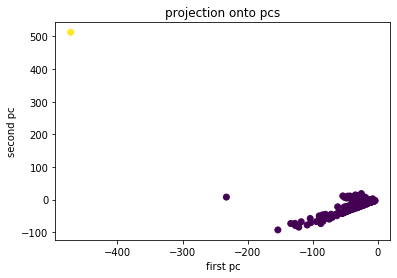

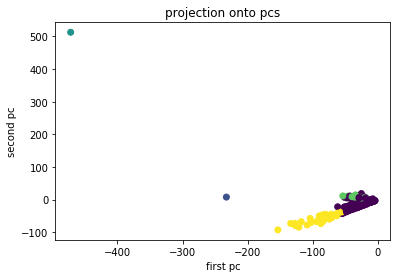

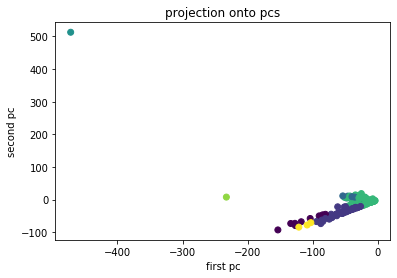

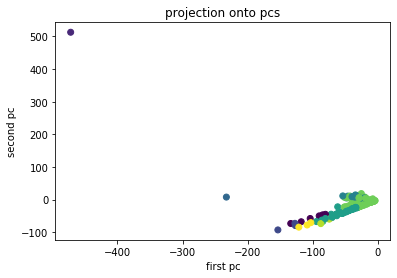

In [111]:
cluster_nums = [2,5,7,10]
for num in cluster_nums:
    plot_clusters(tfidf_mat,num)

Projecting the points onto the first two principle components and then plotting out the cluster results from k-means, we see that there is one clear outlier in the plot on the upper left. We can see that this outlier is the speech by Jimmy Carter in 1981, which is one of the only three speeches that where SOU was only written, and not spoken, so this make sense. 

In [112]:
model = KMeans(n_clusters=2)
sou_clust = model.fit(tfidf_mat)
clusters = sou_clust.predict(tf_idf_mat)
np.argwhere(clusters>0)

In [116]:
(processed_SOUs[206].President,processed_SOUs[206].Year)

('Jimmy Carter', '1981')

Due to the existence of one outlier, the rest of clustering is difficult to see. Given this, I limited the axis of the plot to zoom in on the rest of the clusters.

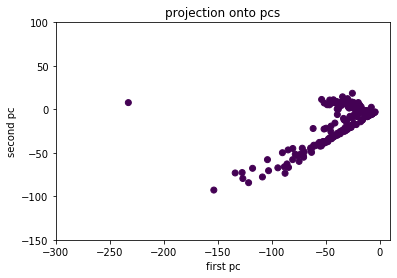

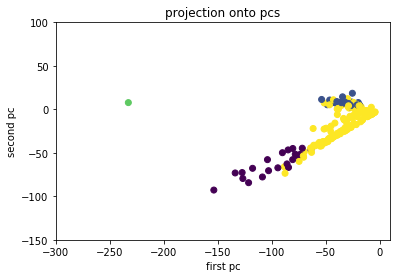

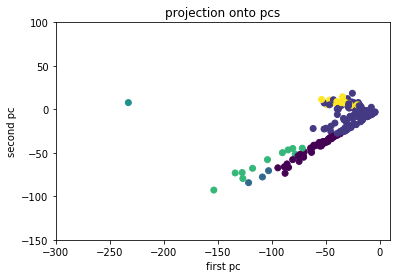

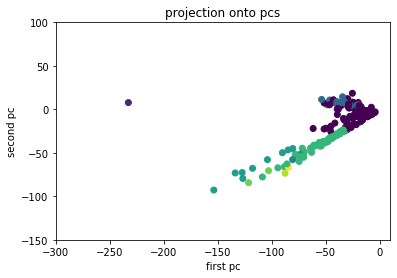

In [117]:
def plot_clusters(tfidf_mat,num_cluster):
    model = KMeans(n_clusters=num_cluster)
    sou_clust = model.fit(tfidf_mat)
    clusters = sou_clust.predict(tf_idf_mat)
    u,s,vt = np.linalg.svd(tf_idf_mat,full_matrices=False)
    scores = np.matmul(u,np.diag(s))
    plt.figure()
    scatter_plot = plt.scatter(scores[:,0],scores[:,1],c=clusters)
    plt.xlabel("first pc")
    plt.ylabel("second pc")
    plt.xlim(-300,10)
    plt.ylim(-150,100)
    plt.title("projection onto pcs")
    
cluster_nums = [2,5,7,10]
for num in cluster_nums:
    plot_clusters(tfidf_mat,num)

We see that the clusters roughly correspond to the position of projection onto the dimension spanned by the first two principle components. We can take a look at the loading of first and second principle corresponding to each word in the vocabulary list, by looking at the top 5 entries with the highest absolute values.

In [128]:
u,s,vt = np.linalg.svd(tf_idf_mat,full_matrices=False)
v = np.transpose(vt)
pc1 = v[:,0]
pc2 = v[:,1]

In [129]:
index_pc1 = pc1.argsort()[-5:][::-1]
index_pc2 = pc2.argsort()[-5:][::-1]

In [136]:
words_pc1 = [cleaned_master_list[i] for i in index_pc1]
words_pc1

[('will', 9593), ('at', 7141), ('congress', 5218), ('on', 9484), ('but', 5707)]

In [138]:
words_pc2 = [cleaned_master_list[i] for i in index_pc2]
words_pc2

[('\x95', 98), ('1980', 89), ('u', 153), ('soviet', 283), ('programs', 505)]

Looking at the words contributing the most to first and second principle components, there isn't a very clear cut interpretation. However, we do see that Soviet has a high loading for principle component number 2, which corresponds to the fact that 1981 was at the time of cold war, and that Jimmy Carter's outlier 1981 speech has high score for principle component 2. We may interpret that some of the clusters represent speeches that were written about the cold war and US-soviet relations, while others at more ordinary times. 